In [1]:
# Fill in your name using the given format
your_name = "Jacobs, Luuk"

In [2]:
# Uncomment for use in Google Colab. Can be ignored if you run notebooks locally.
#!pip install openml --quiet
#!pip install -U scikit-learn --quiet

# Assignment 1
We will study classifiers on the [Kuzushiji dataset](https://www.openml.org/d/41982).
As you can [read in the paper](https://arxiv.org/abs/1812.01718), Kuzushiji is a handwritten 
Japanese script that was used for thousands of years, but most Japanese natives cannot read
it anymore. We'll try to use machine learning to recognize the characters, and translate them to
modern Japanese (Hiragana) characters.

The dataset that we will use contains scanned 28-by-28 pixel images of such handwritten characters.

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("0.24.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:   
    print("OK. You may continue :)")

OK. You may continue :)


In [4]:
# Download Kuzushiji-MNIST data. Takes a while the first time.
# You may receive a warning about data compression but you can ignore that.
data = openml.datasets.get_dataset(41982)
X, y, _, _ = data.get_data(target=data.default_target_attribute);
X = X/265 # Simple scaling 

# These are the names of the modern characters (our 10 classes)
data_classes = {0:"o", 1: "ki", 2: "su", 3: "tsu", 4: "na", 5: "ha", 
                6: "ma", 7: "ya", 8: "re", 9: "wo"}

In [5]:
# Plotting functions. Don't edit these.
%matplotlib inline
from IPython import display

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

# Plots data instances as 28x28 images
def plot_examples(images, labels, row_length=5):
    nr_rows = math.floor(len(images) / row_length)
    if (len(images) % row_length) > 0:
        nr_rows += 1
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(10, 1.3* nr_rows))
    for i, n in enumerate(images):
        if len(images) > row_length:
            axes[math.floor(i/row_length)][i%row_length].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[math.floor(i/row_length)][i%row_length].set_xlabel(data_classes[int(labels[i])])
            axes[math.floor(i/row_length)][i%row_length].set_xticks(())
            axes[math.floor(i/row_length)][i%row_length].set_yticks(())
        else:
            axes[i].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[i].set_xlabel(data_classes[int(labels[i])])
            axes[i].set_xticks(())
            axes[i].set_yticks(())       
    plt.show();

# Plots the coefficients of the given model as 28x28 heatmaps. 
def plot_coefficients(coef, name):
    """ Renders a 28x28 heatmap of the model's trained coefficients.
    Keyword arguments:
    coef -- the model coefficients
    name -- a title for the produced figure
    """
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    fig.suptitle(name)
    ax.imshow(coef.reshape(28,28))
    ax.set_xticks(()), ax.set_yticks(())

### Peeking at the data
If we plot the characters, we see that there is quite some variation. The same
character can be written in a number of different ways.

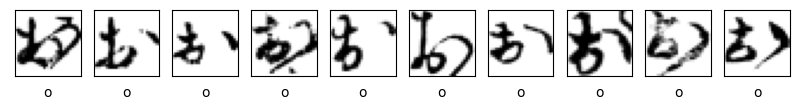

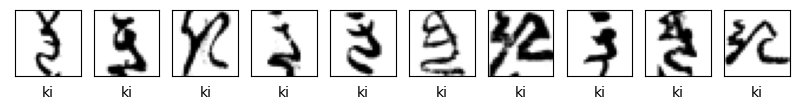

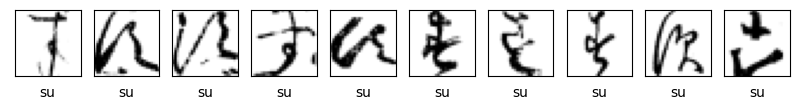

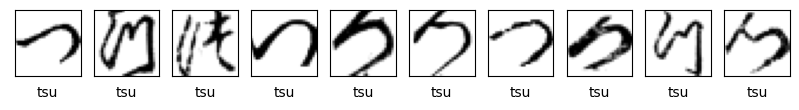

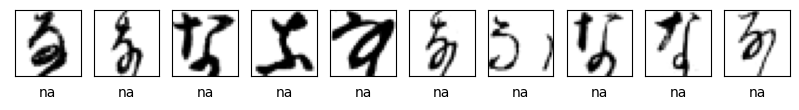

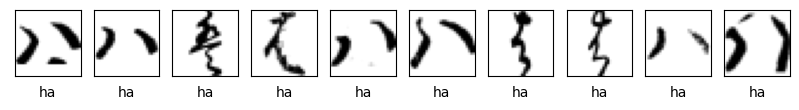

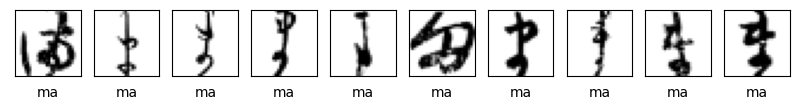

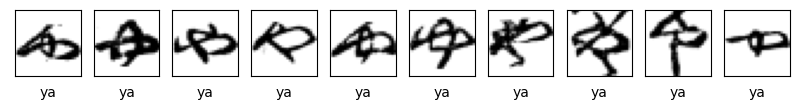

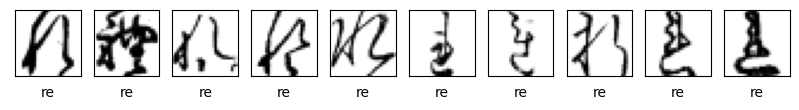

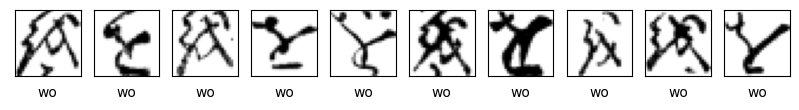

In [6]:
# Gets indices of examples with the given class
def y_class(c):
    return y[y == str(c)].index.values.tolist()[0:10]

for i in range(10):
    plot_examples(X.to_numpy()[y_class(i)], y.to_numpy()[y_class(i)], row_length=10)

### Question 1.1 (2 points)
Implement a function `evaluate_LR` that evaluates a Logistic Regression model for a given regularization constant (C) and returns the train and test score of a 5-fold cross-validation using the accuracy metric.

In [7]:
#from statistics import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Implement
def evaluate_LR(X, y, C):
    """ Evaluate an LR with 5-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    C -- the value for the regularization hyperparameter
    
    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    xval = cross_validate(LogisticRegression(C=C), X, y, return_train_score= True, n_jobs=-1)
    return {'train': np.mean(xval['train_score']), 'test':np.mean(xval['test_score'])}

In [8]:
#Demonstration
from sklearn.model_selection import train_test_split

Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1, random_state=42)
evaluate_LR(Xs,ys,C=1.0)

{'train': 0.9480714285714287, 'test': 0.7397142857142857}

### Question 1.2 (4 points)

Implement a function `plot_curve` that plots the results of `evaluate_LR` on a 10% stratified subsample of the Kuzushiji MNIST dataset vary the C value ranging from 1e-8 to 1e3 (on a log scale, at least 12 values), for the Logistic Regression. You can use the plotting function `plot_live` defined above (carefully read what it does), and add any helper functions you like. Note:  To be clear, you need to pass only 10% of the data to `evaluate_LR`. Using a 10% subsample won't give you optimal performance, but this is meant to make the assignment more doable. If you like you can also use the full dataset.

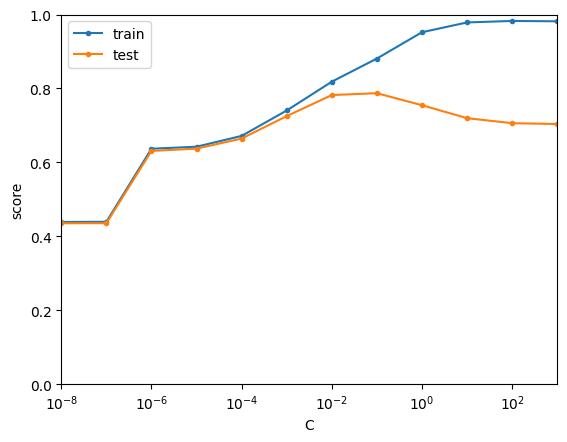

In [9]:
from sklearn.model_selection import train_test_split

def subsample(size):
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=size)
    return Xs, ys

# Implement. Do not change the name or signature of this function.
def plot_curve():
    """ Plots the train and test accuracy of logistic regression on a 10% 
    subsample of the given data for different amounts of regularization.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: a plot as described above, with C on the x-axis and accuracy on 
    the y-axis. 
    """
    Xs, ys = subsample(0.1)
    C_lst = [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,1e2,1e3]
    plot_live(Xs, ys, evaluate_LR, 'C', C_lst)

plot_curve()

### Question 1.3 (2 point)
Interpret the graph. At C=1e-6, is the model underfitting, overfitting, or neither? What about the model trained with C=100?

Below are a number of possible interpretations. Enter the correct answer in value q_1_3 in the code.

'A': Underfitting at C=1e-6, overfitting at C=100.

'B': Overfitting at C=1e-6, underfitting at C=100.

'C': Neither underfitting nor overfitting at C=1e-6, overfitting at C=100.

'D': Neither underfitting nor overfitting at C=1e-6, underfitting at C=100.

'E': Overfitting at C=1e-6, neither underfitting nor overfitting at C=100.

'F': Underfitting at C=1e-6, neither underfitting nor overfitting at C=100.

'G': Neither underfitting nor overfitting at both values for C.

'H': No answer

Add the explanation for choosing your answer.

In [10]:
# Fill in the correct answer. Don't change the name of the variable
q_1_3 ="A"


#### Explenation 1.3

A smaller C means that residuals are penelized less, meaning that you will get a very generic/simple model which implies underfitting if C goes to 0. A sign of underfitting is that the model is to simplistic and hence does not achieve its full potential of accuracy. When looking at the graph you could expect the highest accuracy on the test set when the regularization hyperparameter C is set to a value between 1e-3 and 1. You could also observe that for C = 1e-6, the accuracy is significantly lower than the maximized accuracy, implying that the model might be to simplistic and thus that the model is underfitting. 

A larger C means that residuals are panelized more, meaning that the model will overfit if C goes to infinity. A sign of overfitting is when the training dataset accuracy is significantlly higher than on the test dataset. This is because the model is overfitted on the train data and cannot handle data that is different from the training data, so therefore it has a lower accuracy on the test set since it is not exact the same as the train data. For C = 1e2 we can see that the accuracy on the test set is significantly lower than the train data, hence we see that the Logistic regression with C = 1e2 is overfitting on the train data.

Hence, the graph indicates that the answer should be **A**


### Question 2.1 (4 points)
Use the `plot_coefficients` plotting function to plot a heatmap of the coefficients of three models, one trained with C=10e-6, one with C=0.01, and one with C=10. Only plot the coefficients of the model that separates the character `tsu` from the other characters. You can assume that a one-vs-rest approach is used for multi-class problems, hence the n-th set of coefficients belong to the model that separates the n-th class. You should get three plots in total.

First split the data in a default stratified train-test split. Train the models on the training data and score the accuracy on the test data. Add the C-value and accuracy to the title of the plots. 

Note: You may get convergence warnings. If so, just increase the number of optimization iterations (`max_iter`). Especially models with high C values can take longer to converge (can you guess why?). You can also choose to ignore these warnings since they won't affect the results much.  
Note 2: Recent versions of scikit-learn use a more sophisticated approach than simple one-vs-all, but will still produce one model per class.

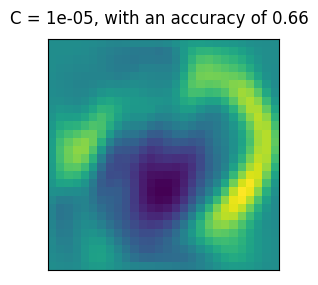

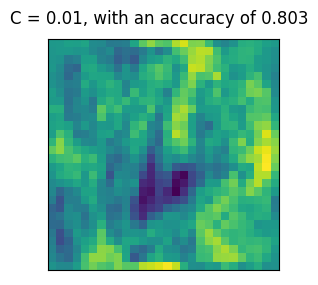

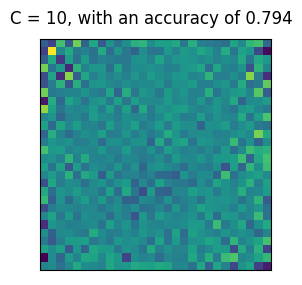

In [11]:
# Implement. Do not change the name or signature of this function.
def plot_tsu_coefficients(X,y):
    """ Plots 28x28 heatmaps showing the coefficients of three Logistic 
    Regression models, each with different amounts of regularization values.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: 3 plots, as described above.
    """
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
    for C in [10e-6, 0.01, 10]:
        lr = LogisticRegression(C=C, max_iter=10000).fit(X_train, y_train)
        acc = lr.score(X_test, y_test)
        plot_coefficients(lr.coef_[3], 'C = {}, with an accuracy of {}'.format(C, round(acc,3)))
    
plot_tsu_coefficients(X,y)

## Question 2.2 (2 points)
Interpret the results. Which model works best? What is each of the models paying attention to when making predictions? Does that make sense - i.e. did the model learn something useful about the character *tsu*? Compare this to the results
of question 1.2 and 1.3: does that help explain the accuracy results?

#### my answer:

As expected from the plot in question 1.2, the model using C = 1e-2 results in the highest accuracy, and therefore seems to work best based on accuracy.

the model using C = 10e-6 is expected to underfit based on the plot from question 1.2. You could see from the plot of question 2.1 that this model returns a heatmap with a relatively simple shape in what you could somewhat imagene a tsu shape. It does make sense since underfitting is expected to lead to a relatively simple and average tsu shape. So the model did learn something usefull, only because it is relatively simple I expect it to have more trouble with complexly writen tsus, therefore I expect already at slightly more complex tsus to be below the classification treshold. Which should be explaining why the shape in the heatmap looks the most of all plots like a tsu, but the accuracy is actually the lowest of them all. Also the accuracy results of all plots in question 2.1 are alligned with the accuracies in the plot of question 1.2.

For C = 0.01, the model has the highest accuracy, which is alligned with the expectations made in question 1.3. Besides, the shape in the heatmap of question 2.1 looks complex, but whit a creative mind that is actively looking to see a tsu, it is still possible to form tsu shapes which are mostly located in the brightest parts of the heatmap. This complex shaped heatmap looks like it found a balance in giveing room for different variants of the tsu shape, whilst being enough like a tsu shape. Hence, I think that the model learned something usefull, which makes sense. Moreover, the expectation from question 1.3 alligns with the model finding a balance between under- and overfitting.

For C = 10, the heatmap retuns a somewhat uniform/random shape, which does not make much sense. from the plot in question 1.2 and the expectations from question 1.3 indicate that the model is likely to overfit. when looking at the heatmap of question 2.1, one could agree that it seems to be overfitted. The accuracy also alligns with the results from the plot in question 1.2.



## Question 3.1 (4 points)
Let's focus more on the character 'tsu' and the behavior of the model with C=1e-6.

First split the data again in a default stratified train-test split. Train the models on the training data and produce the predictions on the test data.

Next, take the test examples which actually represent 'tsu'. From these, identify the ones which are predicted correctly and which ones are not.

Finally, plot these examples using the `plot_examples` function, together with the predicted class (character). Create two plots: one with 20 examples of 'tsu' characters which are predicted correctly, and a second with 20 examples of 'tsu' characters which are predicted incorrectly by this model.

20 examples of 'tsu' characters which are predicted correctly


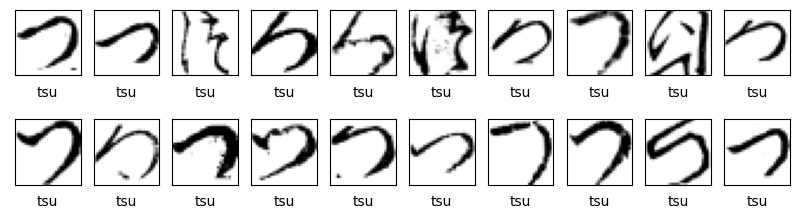

20 examples of 'tsu' characters which are predicted incorrectly by this model


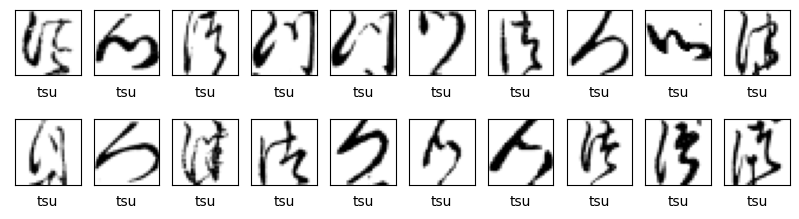

In [14]:
def analyze_tsu():
  # Free form coding. Produce the two plots as requested. 
  # Important: the plots must be correct when the notebook is restarted and run from top to bottom.
  X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
  lr = LogisticRegression(C=1e-6, max_iter=10000).fit(X_train, y_train)
  y_pred = pd.Series(lr.predict(X_test), y_test.index)
  i_tsu = y_test[y_test == str(3)].index.values.tolist()
  y_tsu = y_pred[y_test == str(3)]
  y_true = y_tsu[y_tsu == str(3)].index.values.tolist()
  y_false = y_tsu[y_tsu != str(3)].index.values.tolist()
  print("20 examples of 'tsu' characters which are predicted correctly")
  plot_examples(X_test.loc[y_true].head(20).to_numpy(), y_test.loc[y_true].head(20).to_numpy(), row_length=10)
  print("20 examples of 'tsu' characters which are predicted incorrectly by this model")
  plot_examples(X_test.loc[y_false].head(20).to_numpy(), y_test.loc[y_false].head(20).to_numpy(), row_length=10)

analyze_tsu()

## Question 3.2 (2 points)
Interpret the results. Can you explain which kinds of 'tsu' characters are predicted correctly and which ones are not? Compare this with what you observed in question 2.1 and 2.2. What does that tell you about the model?

'tsu' character which is predicted correctly, and looks relatively simple


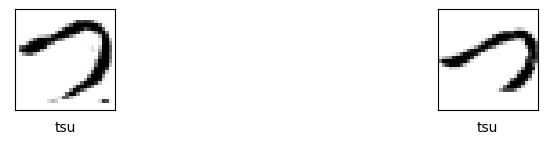

'tsu' character which is predicted incorrectly, and looks relatively complex


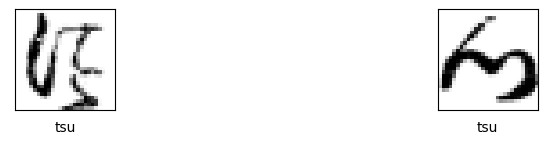

In [19]:
#You can add the code here for the analysis. 
#This code is optional as the grading will be done based on the explanation provided below. However, the code will help you to get insights.
def single_tsu():
  # Free form coding. Produce the two plots as requested. 
  # Important: the plots must be correct when the notebook is restarted and run from top to bottom.
  X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
  lr = LogisticRegression(C=1e-6, max_iter=10000).fit(X_train, y_train)
  y_pred = pd.Series(lr.predict(X_test), y_test.index)
  i_tsu = y_test[y_test == str(3)].index.values.tolist()
  y_tsu = y_pred[y_test == str(3)]
  y_true = y_tsu[y_tsu == str(3)].index.values.tolist()
  y_false = y_tsu[y_tsu != str(3)].index.values.tolist()
  print("'tsu' characters which are predicted correctly, and look relatively simple")
  plot_examples(X_test.loc[y_true].head(2).to_numpy(), y_test.loc[y_true].head(2).to_numpy(), row_length=2)
  print("'tsu' characters which are predicted incorrectly, and look relatively complex")
  plot_examples(X_test.loc[y_false].head(2).to_numpy(), y_test.loc[y_false].head(2).to_numpy(), row_length=2)

single_tsu()

## My answer:

The tsus that are actually classified correctly are all relatively similar, whilst the tsus in that are classified incorrectly are all relatively different from the tsus that are classified truely. You could consider the worongly classified tsus as more complex shapes. The correctly classified tsus in the plot above are an example of what I mean with a simple/regular tsu shape. You could easily spot the differens with the wrongly clasified tsus in the plot above. Where the right one, still looks somewhat similar to the regular shapes. But the left wrongly classified tsu character seems almost a different character, given how different it is. Obviously the model has troubles with that. It might be the case that tsu can be written in 2 different ways, or that this character is wrongly labeled. In case the tsu can be written in 2 ways, it might be better to distingush the charactors, since that will make it easier to classify. Moreover, garbish in garbish out, so all wrongly labeled characters have a negative impact on the model.

The model with C=1e-2 from question 2.1 leaves more room for complexer tsu characters, so also for the differently/very complexly written characters. Which is likely why that model achieves the highest accuracy. Whilst the model with C=10e-6 is clearly not capable to classify the complexer tsu characters, which allignes with the expectations made in question 2.2. So an improvement to the model might be to distingush the two very different shapes.